# Micro & Macro Analysis: Model Comparison

This notebook visualizes and compares the micro and macro evaluation results for all datasets (eudract, allergen, flight). Duplicate code is removed and plotting is handled by reusable functions. Each dataset retains its own graphs and results.

In [1]:
import json
import matplotlib.pyplot as plt
import numpy as np
import os
from typing import Dict

# Color palette for all models
COLORS = ['#FF6F61', '#6B5B95', '#88B04B', '#F7CAC9', '#92A8D1', '#955251', '#B565A7', '#009B77']

METRICS = ["accuracy", "f1_score", "precision", "recall"]

def load_model_data(base_path: str, files: Dict[str, str]) -> Dict[str, dict]:
    model_data = {}
    for model, file_name in files.items():
        with open(os.path.join(base_path, file_name), 'r') as f:
            model_data[model] = json.load(f)
    return model_data

def plot_micro_analysis(model_data: Dict[str, dict], dataset_name: str):
    models = list(model_data.keys())
    x = np.arange(len(METRICS))
    width = 0.95 / len(models)
    gap = 0.5  # Add a gap between metric groups
    # Calculate new x positions with extra gap between metric groups
    x_with_gaps = []
    for i in range(len(METRICS)):
        if i == 0:
            x_with_gaps.append(0)
        else:
            x_with_gaps.append(x_with_gaps[-1] + 1 + gap)
    x_with_gaps = np.array(x_with_gaps)
    fig, ax = plt.subplots(figsize=(10, 6))
    for i, (model, color) in enumerate(zip(models, COLORS)):
        bar_shift = 0.01
        bar_pos = x_with_gaps + (i - (len(models) - 1) / 2) * width + (i - 0.5) * bar_shift
        rects = ax.bar(bar_pos,
                       [model_data[model][metric] for metric in METRICS],
                       width - bar_shift, label=model, color=color)
        for rect in rects:
            height = rect.get_height()
            ax.annotate(
                f"{height:.3f}",
                xy=(rect.get_x() + rect.get_width() / 2, height),
                xytext=(0, 8),
                textcoords="offset points",
                ha="center",
                va="bottom",
                rotation=45,
            )
    y_max = max([model_data[model][metric] for model in models for metric in METRICS])
    ax.set_ylim(0, y_max + 0.5)
    ax.set_ylabel("Score")
    ax.set_title(f"{dataset_name} - Micro Analysis: Model Comparison by Metric")
    ax.set_xticks(x_with_gaps)
    ax.set_xticklabels(METRICS, rotation=90)
    ax.legend()
    plt.tight_layout(pad=2.0)
    plt.show()

def plot_macro_analysis(model_data: Dict[str, dict], dataset_name: str, show_annotations: bool = False):
    column_names = list(model_data.values())[0]["column_names"]
    models = list(model_data.keys())
    values_per_col = {m: {col["column_name"]: col for col in model_data[m]["stats"]} for m in models}
    fig, axes = plt.subplots(nrows=2, figsize=(14, 8), sharex=True)
    fig.suptitle(f"{dataset_name} - Macro Analysis: Model Comparison by Column and Metric", fontsize=22, y=1.02)
    metrics_to_plot = ['precision', 'recall']
    x = np.arange(len(column_names))
    width = 0.8 / len(models)
    for ax, metric in zip(axes, metrics_to_plot):
        bar_values = []
        for col in column_names:
            bar_values.append([values_per_col[m][col][metric] for m in models])
        bar_values = np.array(bar_values)
        for i, (model, color) in enumerate(zip(models, COLORS)):
            bar_pos = x + i * width - (width * (len(models) - 1) / 2)
            rects = ax.bar(bar_pos, bar_values[:, i], width, label=model, color=color)
            if show_annotations:
                for rect in rects:
                    height = rect.get_height()
                    ax.annotate(
                        f"{height:.2f}",
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 8),
                        textcoords="offset points",
                        ha="center",
                        va="bottom",
                        rotation=45,
                        fontsize=10
                    )
        y_max = bar_values.max()
        ax.set_ylim(0, y_max + 0.5)
        ax.set_ylabel(metric, fontsize=18)
        ax.tick_params(axis='y', labelsize=14)
    axes[-1].set_xticks(x)
    axes[-1].set_xticklabels(column_names, rotation=90, ha='right', fontsize=14)
    fig.legend(models, loc='upper center', ncol=len(models), frameon=False, bbox_to_anchor=(0.5, 0.93), fontsize=12)
    plt.tight_layout(rect=(0, 0, 1, 0.90), pad=2.0)
    plt.show()

def plot_difference_vs_parker(model_data: Dict[str, dict], dataset_name: str):
    """
    Plots the difference in metrics for each model compared to Parker (baseline).
    Positive bar: model outperforms Parker. Negative: underperforms.
    """
    baseline = "Parker"
    if baseline not in model_data:
        print(f"Baseline '{baseline}' not found in model_data.")
        return
    models = [m for m in model_data.keys() if m != baseline]
    x = np.arange(len(METRICS))
    width = 0.95 / len(models)
    gap = 0.5
    x_with_gaps = []
    for i in range(len(METRICS)):
        if i == 0:
            x_with_gaps.append(0)
        else:
            x_with_gaps.append(x_with_gaps[-1] + 1 + gap)
    x_with_gaps = np.array(x_with_gaps)
    fig, ax = plt.subplots(figsize=(10, 6))
    for i, (model, color) in enumerate(zip(models, COLORS)):
        bar_shift = 0.01
        bar_pos = x_with_gaps + (i - (len(models) - 1) / 2) * width + (i - 0.5) * bar_shift
        differences = [model_data[model][metric] - model_data[baseline][metric] for metric in METRICS]
        rects = ax.bar(bar_pos, differences, width - bar_shift, label=model, color=color)
        for rect, diff in zip(rects, differences):
            ax.annotate(f"{diff:+.3f}",
                        xy=(rect.get_x() + rect.get_width() / 2, diff),
                        xytext=(0, 8 if diff >= 0 else -18),
                        textcoords="offset points",
                        ha="center",
                        va="bottom" if diff >= 0 else "top",
                        rotation=45)
    y_min = min([model_data[model][metric] - model_data[baseline][metric] for model in models for metric in METRICS])
    y_max = max([model_data[model][metric] - model_data[baseline][metric] for model in models for metric in METRICS])
    ax.set_ylim(y_min - 0.1, y_max + 0.1)
    ax.axhline(0, color='black', linewidth=1, linestyle='--')
    ax.set_ylabel("Difference vs Parker")
    ax.set_title(f"{dataset_name} - Difference to Parker by Metric")
    ax.set_xticks(x_with_gaps)
    ax.set_xticklabels(METRICS, rotation=90)
    ax.legend()
    plt.tight_layout(pad=2.0)
    plt.show()

def plot_macro_difference_vs_parker(model_data: Dict[str, dict], dataset_name: str):
    """
    Plots the difference in macro metrics (precision, recall) for each model compared to Parker (baseline),
    for each column. Positive bar: model outperforms Parker. Negative: underperforms.
    """
    baseline = "Parker"
    if baseline not in model_data:
        print(f"Baseline '{baseline}' not found in model_data.")
        return
    column_names = list(model_data[baseline]["column_names"])
    models = [m for m in model_data.keys() if m != baseline]
    values_per_col = {m: {col["column_name"]: col for col in model_data[m]["stats"]} for m in models}
    baseline_per_col = {col["column_name"]: col for col in model_data[baseline]["stats"]}
    fig, axes = plt.subplots(nrows=2, figsize=(14, 8), sharex=True)
    fig.suptitle(f"{dataset_name} - Macro Difference to Parker by Column and Metric", fontsize=22, y=1.02)
    metrics_to_plot = ['precision', 'recall']
    x = np.arange(len(column_names))
    width = 0.8 / len(models)
    for ax, metric in zip(axes, metrics_to_plot):
        bar_values = []
        for col in column_names:
            bar_values.append([
                values_per_col[m][col][metric] - baseline_per_col[col][metric] for m in models
            ])
        bar_values = np.array(bar_values)
        for i, (model, color) in enumerate(zip(models, COLORS)):
            bar_pos = x + i * width - (width * (len(models) - 1) / 2)
            rects = ax.bar(bar_pos, bar_values[:, i], width, label=model, color=color)
            for rect, diff in zip(rects, bar_values[:, i]):
                ax.annotate(f"{diff:+.2f}",
                            xy=(rect.get_x() + rect.get_width() / 2, diff),
                            xytext=(0, 8 if diff >= 0 else -18),
                            textcoords="offset points",
                            ha="center",
                            va="bottom" if diff >= 0 else "top",
                            rotation=45,
                            fontsize=10)
        y_min = bar_values.min()
        y_max = bar_values.max()
        ax.set_ylim(y_min - 0.1, y_max + 0.1)
        ax.axhline(0, color='black', linewidth=1, linestyle='--')
        ax.set_ylabel(f"{metric} Difference vs Parker", fontsize=18)
        ax.tick_params(axis='y', labelsize=14)
    axes[-1].set_xticks(x)
    axes[-1].set_xticklabels(column_names, rotation=90, ha='right', fontsize=14)
    fig.legend(models, loc='upper center', ncol=len(models), frameon=False, bbox_to_anchor=(0.5, 0.93), fontsize=12)
    plt.tight_layout(rect=(0, 0, 1, 0.90), pad=2.0)
    plt.show()

# EudraCT Dataset

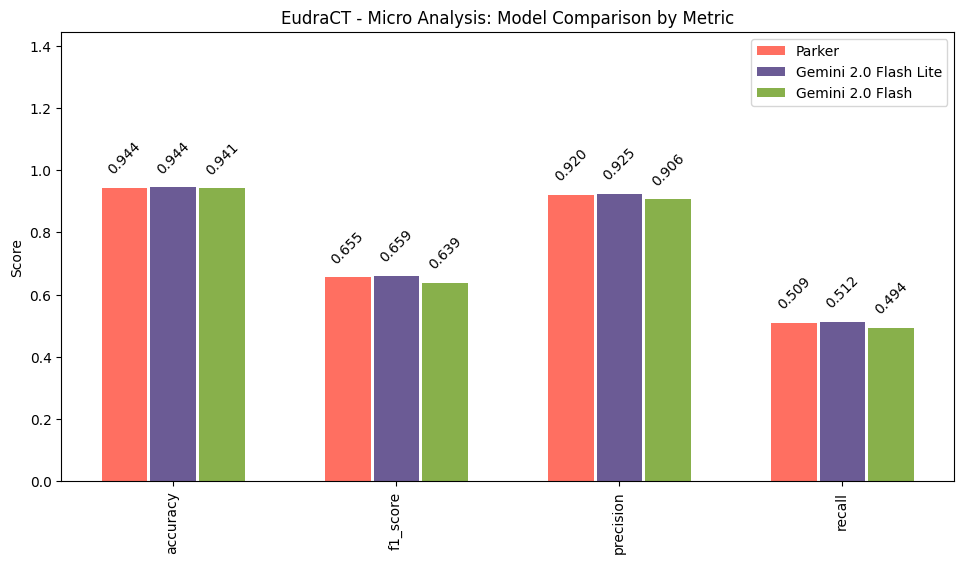

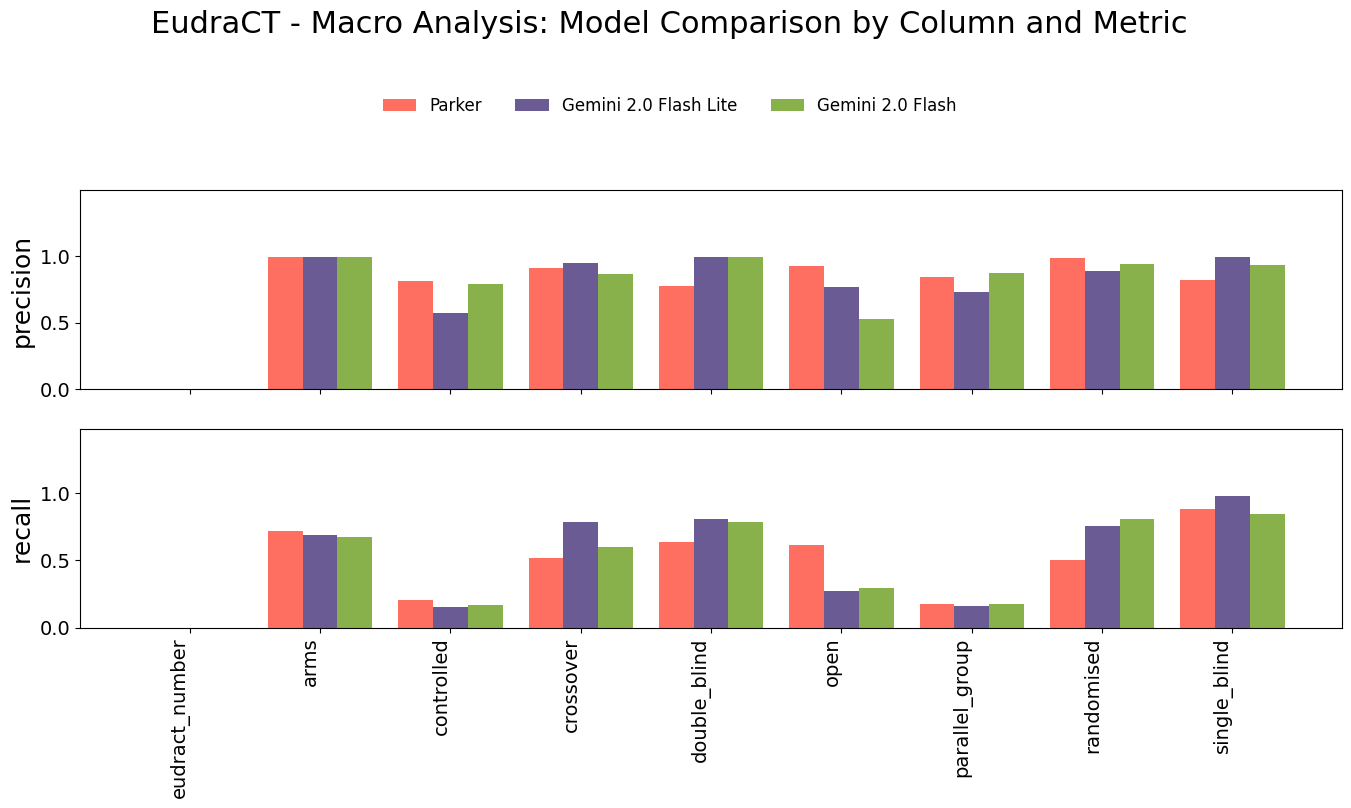

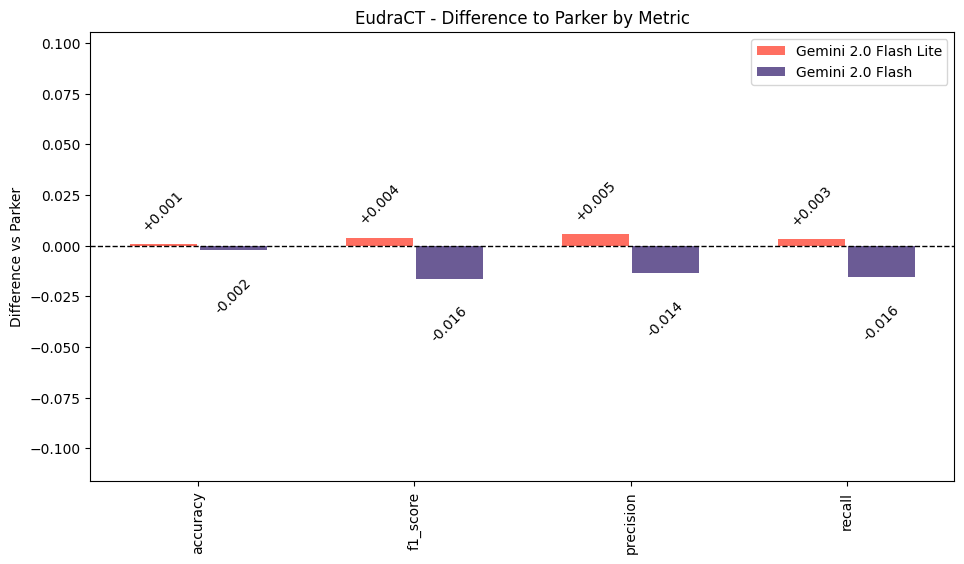

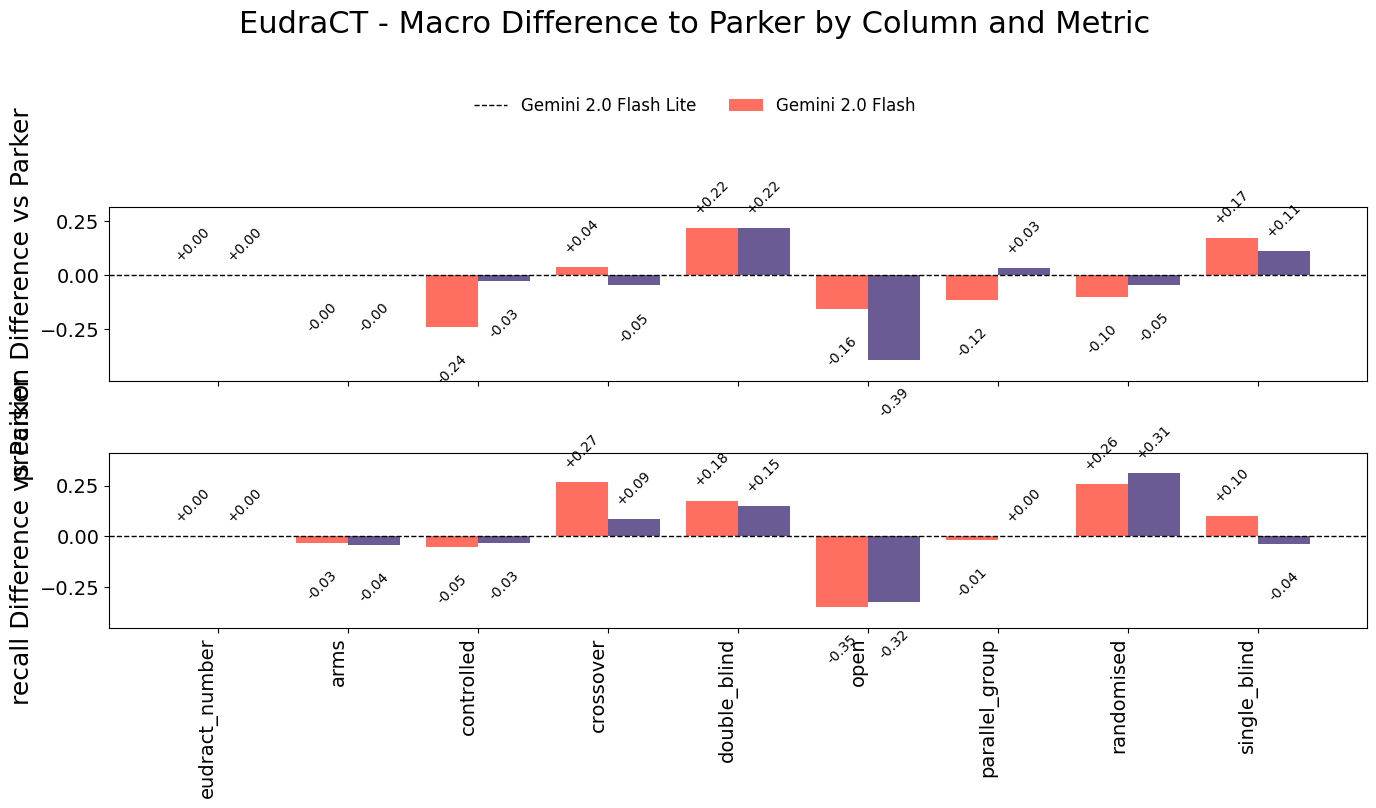

In [ ]:
# EudraCT paths and files
base_path = os.path.join('.', 'eudract')
micro_files = {
    "Parker": "parker_results_micro.json",
    "Gemini 2.0 Flash Lite (0 rows context)": "gemini_2_0_flash_lite_0_rows_context_results_micro.json",
    "Gemini 2.0 Flash Lite (50 rows context)": "gemini_2_0_flash_lite_50_rows_context_results_micro.json",
    "Gemini 2.0 Flash Lite (200 rows context)": "gemini_2_0_flash_lite_200_rows_context_results_micro.json",
    "GPT-4.1 Mini (0 rows context)": "gpt_4_1_mini_2025_04_14_0_rows_context_results_micro.json",
    "GPT-4.1 Mini (50 rows context)": "gpt_4_1_mini_2025_04_14_50_rows_context_results_micro.json",
    "GPT-4.1 Mini (200 rows context)": "gpt_4_1_mini_2025_04_14_200_rows_context_results_micro.json",
}
macro_files = {
    "Parker": "parker_results_macro.json",
    "Gemini 2.0 Flash Lite (0 rows context)": "gemini_2_0_flash_lite_0_rows_context_results_macro.json",
    "Gemini 2.0 Flash Lite (50 rows context)": "gemini_2_0_flash_lite_50_rows_context_results_macro.json",
    "Gemini 2.0 Flash Lite (200 rows context)": "gemini_2_0_flash_lite_200_rows_context_results_macro.json",
    "GPT-4.1 Mini (0 rows context)": "gpt_4_1_mini_2025_04_14_0_rows_context_results_macro.json",
    "GPT-4.1 Mini (50 rows context)": "gpt_4_1_mini_2025_04_14_50_rows_context_results_macro.json",
    "GPT-4.1 Mini (200 rows context)": "gpt_4_1_mini_2025_04_14_200_rows_context_results_macro.json",
}
# Micro
model_data = load_model_data(base_path, micro_files)
plot_micro_analysis(model_data, "EudraCT")
# Macro
model_data = load_model_data(base_path, macro_files)
plot_macro_analysis(model_data, "EudraCT")
# Difference vs Parker (Micro)
plot_difference_vs_parker(load_model_data(base_path, micro_files), "EudraCT")
# Difference vs Parker (Macro)
plot_macro_difference_vs_parker(load_model_data(base_path, macro_files), "EudraCT")

# Allergen Dataset

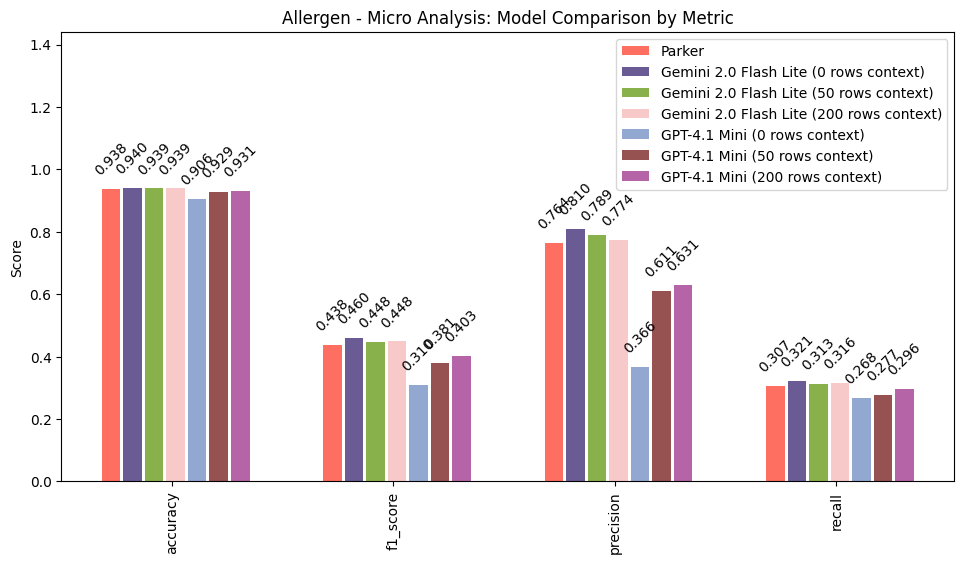

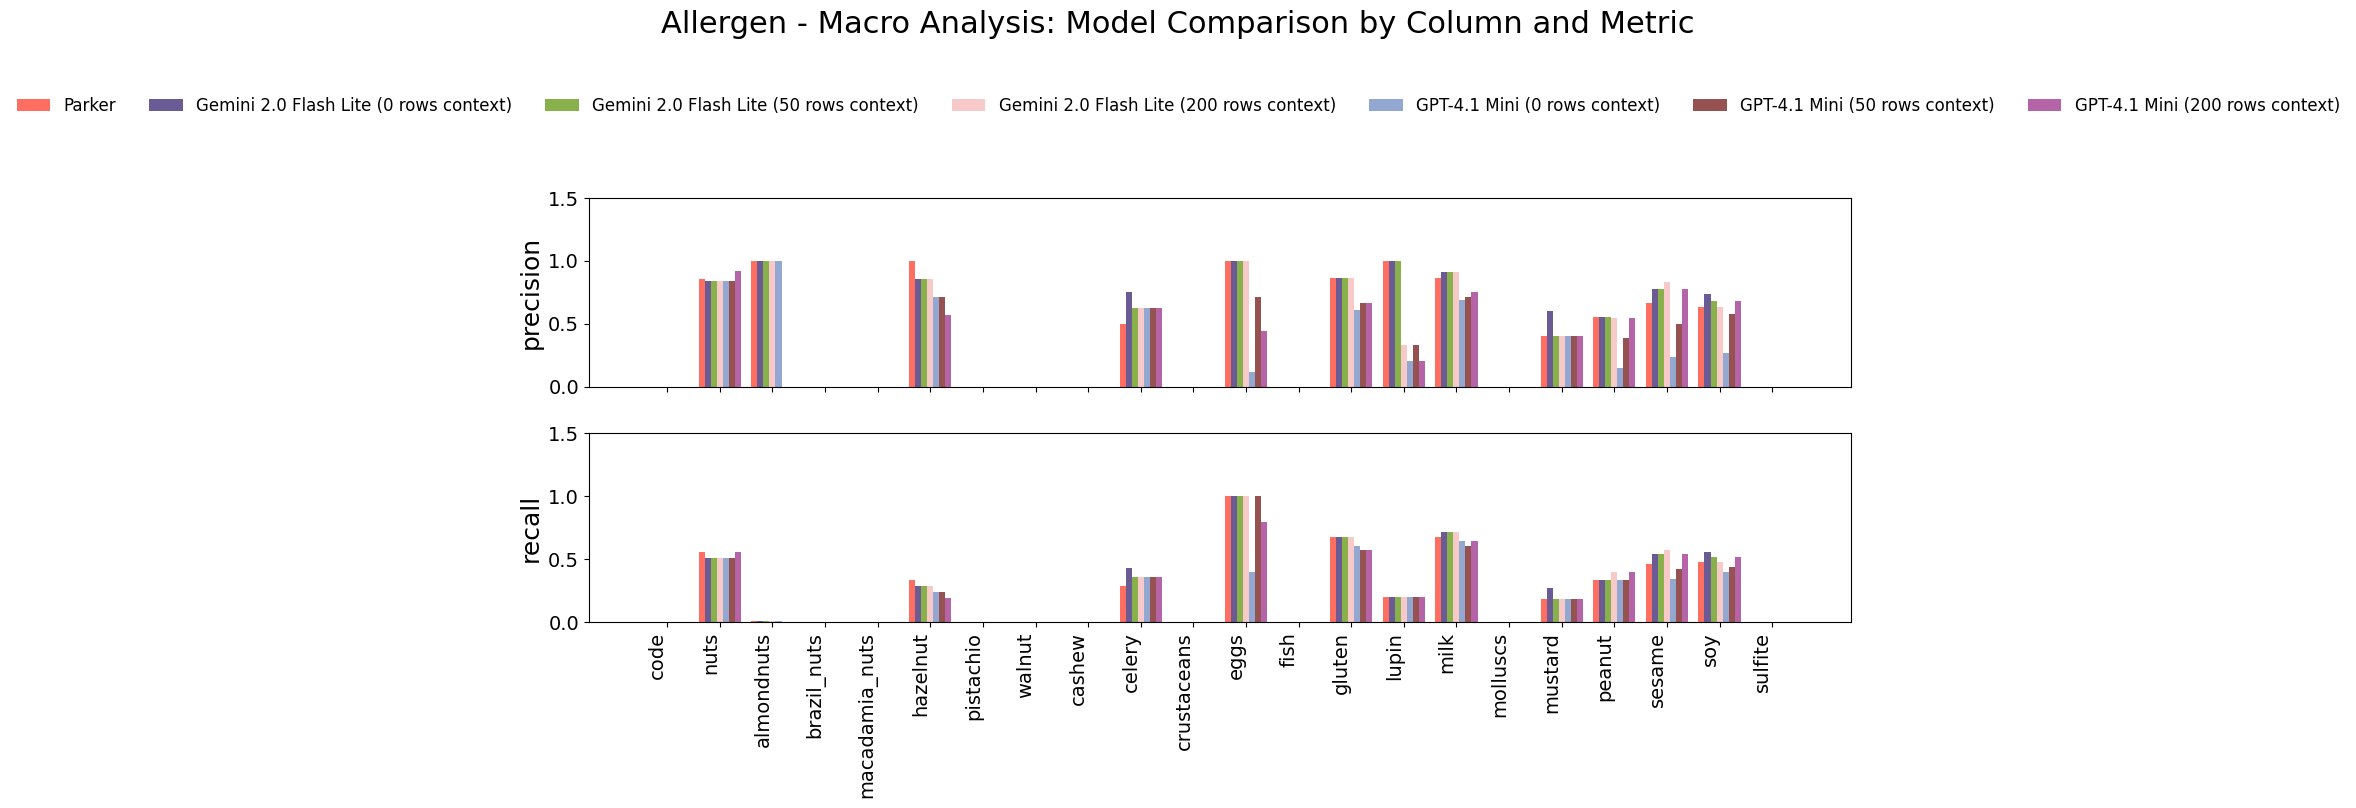

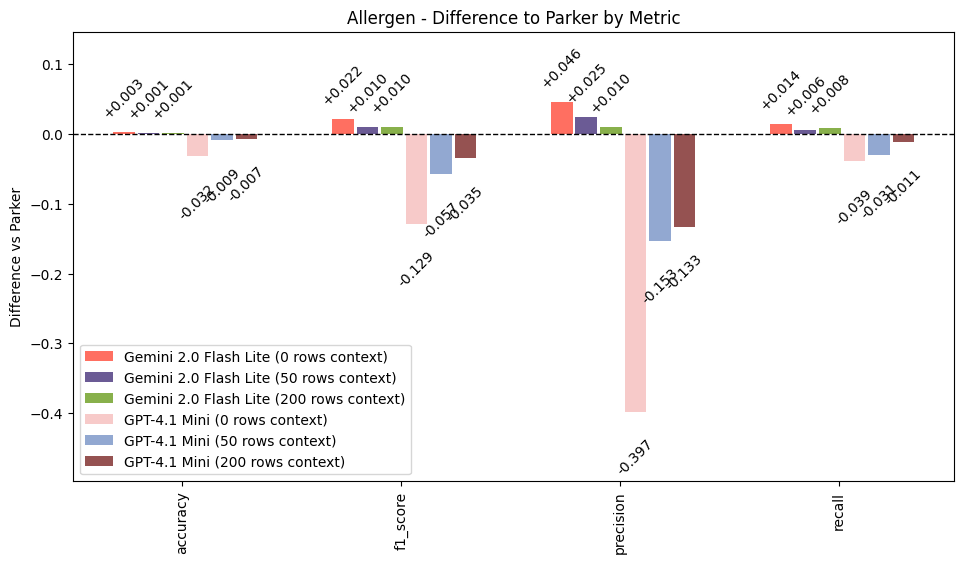

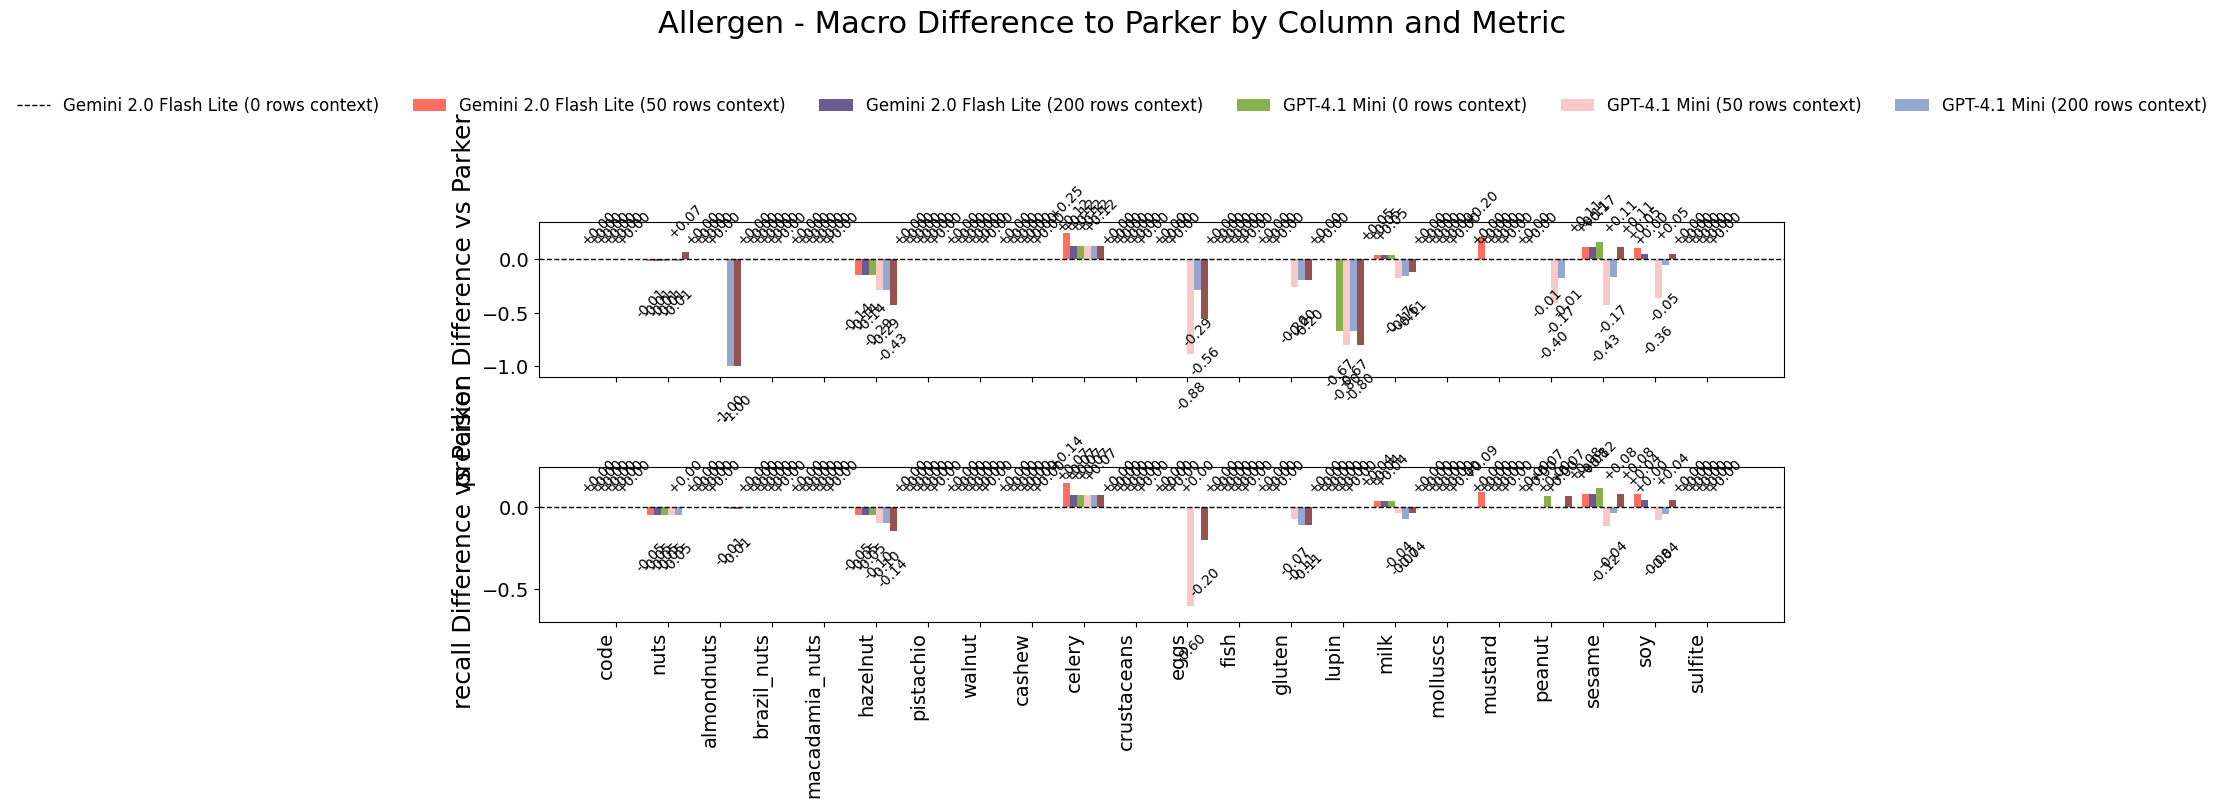

In [3]:
# Allergen paths and files
base_path = os.path.join('.', 'allergen')
micro_files = {
    "Parker": "parker_results_micro.json",
    "Gemini 2.0 Flash Lite (0 rows context)": "gemini_2_0_flash_lite_0_rows_context_results_micro.json",
    "Gemini 2.0 Flash Lite (50 rows context)": "gemini_2_0_flash_lite_50_rows_context_results_micro.json",
    "Gemini 2.0 Flash Lite (200 rows context)": "gemini_2_0_flash_lite_200_rows_context_results_micro.json",
    "GPT-4.1 Mini (0 rows context)": "gpt_4_1_mini_2025_04_14_0_rows_context_results_micro.json",
    "GPT-4.1 Mini (50 rows context)": "gpt_4_1_mini_2025_04_14_50_rows_context_results_micro.json",
    "GPT-4.1 Mini (200 rows context)": "gpt_4_1_mini_2025_04_14_200_rows_context_results_micro.json",
}
macro_files = {
    "Parker": "parker_results_macro.json",
    "Gemini 2.0 Flash Lite (0 rows context)": "gemini_2_0_flash_lite_0_rows_context_results_macro.json",
    "Gemini 2.0 Flash Lite (50 rows context)": "gemini_2_0_flash_lite_50_rows_context_results_macro.json",
    "Gemini 2.0 Flash Lite (200 rows context)": "gemini_2_0_flash_lite_200_rows_context_results_macro.json",
    "GPT-4.1 Mini (0 rows context)": "gpt_4_1_mini_2025_04_14_0_rows_context_results_macro.json",
    "GPT-4.1 Mini (50 rows context)": "gpt_4_1_mini_2025_04_14_50_rows_context_results_macro.json",
    "GPT-4.1 Mini (200 rows context)": "gpt_4_1_mini_2025_04_14_200_rows_context_results_macro.json",
}
# Micro
model_data = load_model_data(base_path, micro_files)
plot_micro_analysis(model_data, "Allergen")
# Macro
model_data = load_model_data(base_path, macro_files)
plot_macro_analysis(model_data, "Allergen")
# Difference vs Parker (Micro)
plot_difference_vs_parker(load_model_data(base_path, micro_files), "Allergen")
# Difference vs Parker (Macro)
plot_macro_difference_vs_parker(load_model_data(base_path, macro_files), "Allergen")

# Flight Dataset

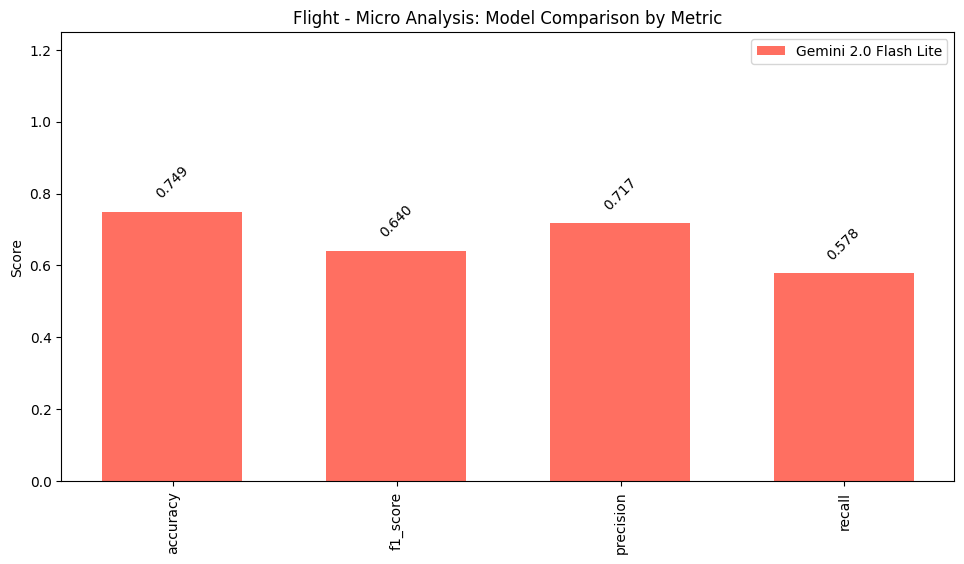

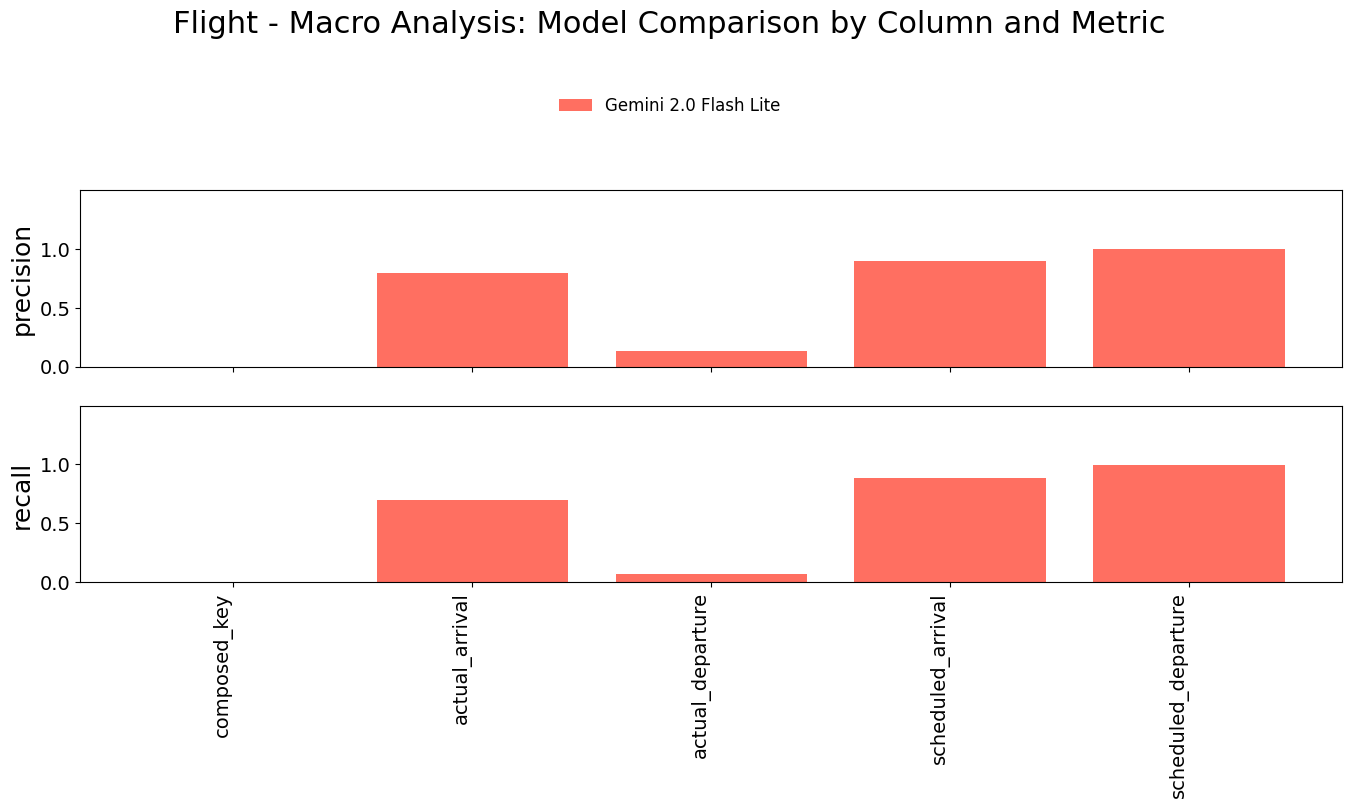

Baseline 'Parker' not found in model_data.
Baseline 'Parker' not found in model_data.


In [4]:
# Flight paths and files
base_path = os.path.join('.','flight')
micro_files = {
    # "Parker":  'parker_results_micro.json',
    "Gemini 2.0 Flash Lite": 'gemini_2_0_flash_lite_results_micro.json',
}
macro_files = {
    # "Parker":  'parker_results_macro.json',
    "Gemini 2.0 Flash Lite": 'gemini_2_0_flash_lite_results_macro.json',
}
# Micro
model_data = load_model_data(base_path, micro_files)
plot_micro_analysis(model_data, "Flight")
# Macro
model_data = load_model_data(base_path, macro_files)
plot_macro_analysis(model_data, "Flight")
# Difference vs Parker (Micro)
plot_difference_vs_parker(load_model_data(base_path, micro_files), "Flight")
# Difference vs Parker (Macro)
plot_macro_difference_vs_parker(load_model_data(base_path, macro_files), "Flight")

# Radiology Dataset

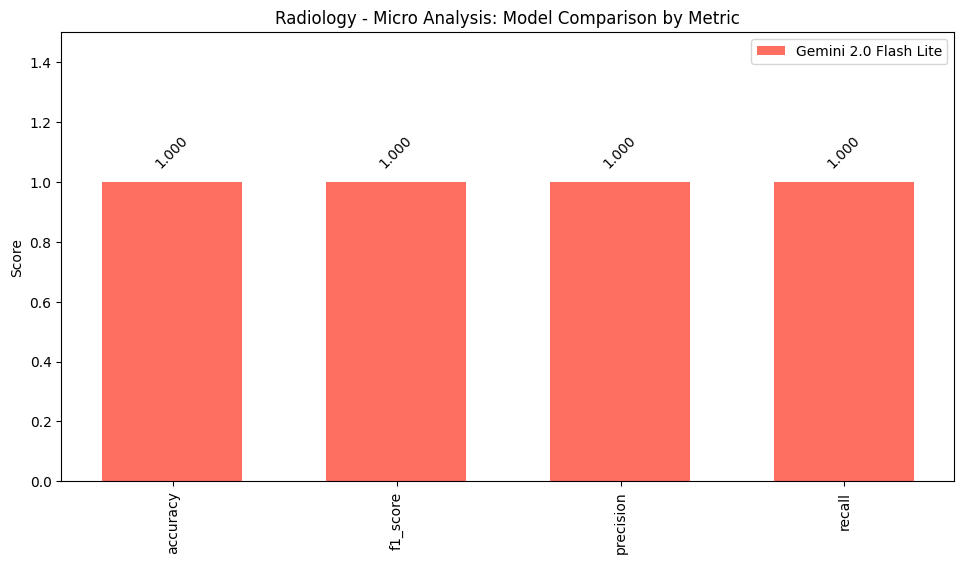

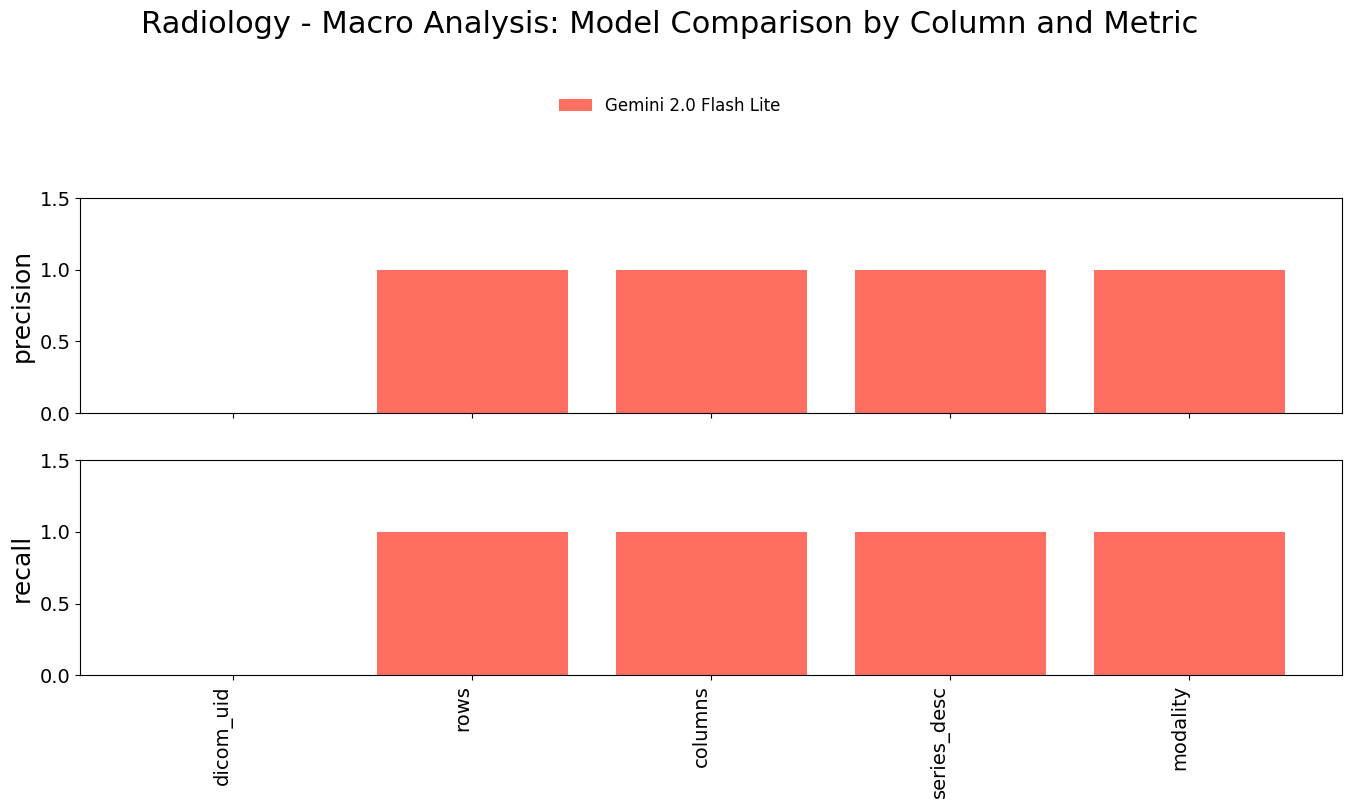

Baseline 'Parker' not found in model_data.
Baseline 'Parker' not found in model_data.


In [5]:
# Radiology paths and files
base_path = os.path.join('.', 'radiology_self_generated')
micro_files = {
    "Gemini 2.0 Flash Lite": 'gemini_2_0_flash_lite_results_micro.json',
}
macro_files = {
    "Gemini 2.0 Flash Lite": 'gemini_2_0_flash_lite_results_macro.json',
}
# Micro
model_data = load_model_data(base_path, micro_files)
plot_micro_analysis(model_data, "Radiology")
# Macro
model_data = load_model_data(base_path, macro_files)
plot_macro_analysis(model_data, "Radiology")
# Difference vs Parker (Micro)
plot_difference_vs_parker(load_model_data(base_path, micro_files), "Radiology")
# Difference vs Parker (Macro)
plot_macro_difference_vs_parker(load_model_data(base_path, macro_files), "Radiology")